In [2]:
from typing import Mapping, Any

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import wget
import zipfile

In [3]:
file_path = "./datasets/hymenoptera_data.zip"
dir_path = "./datasets/hymenoptera_data"

if not os.path.exists(dir_path):
    wget.download("https://download.pytorch.org/tutorial/hymenoptera_data.zip", out=file_path)
    
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
        
    os.remove(file_path)

In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "./datasets/hymenoptera_data/hymenoptera_data/"

image_datasets = {x: datasets.ImageFolder(data_dir + x, data_transforms[x]) for x in ["train", "val"]}

In [5]:
train_dataloader = DataLoader(image_datasets["train"], batch_size=32, shuffle=True)

val_dataloader = DataLoader(image_datasets["val"], batch_size=128, shuffle=False)

In [6]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: ./datasets/hymenoptera_data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(244, 244), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: ./datasets/hymenoptera_data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(244, 244))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [34]:
loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 244, 'val': 153}

In [9]:
class_names = image_datasets["train"].classes
class_names

['ants', 'bees']

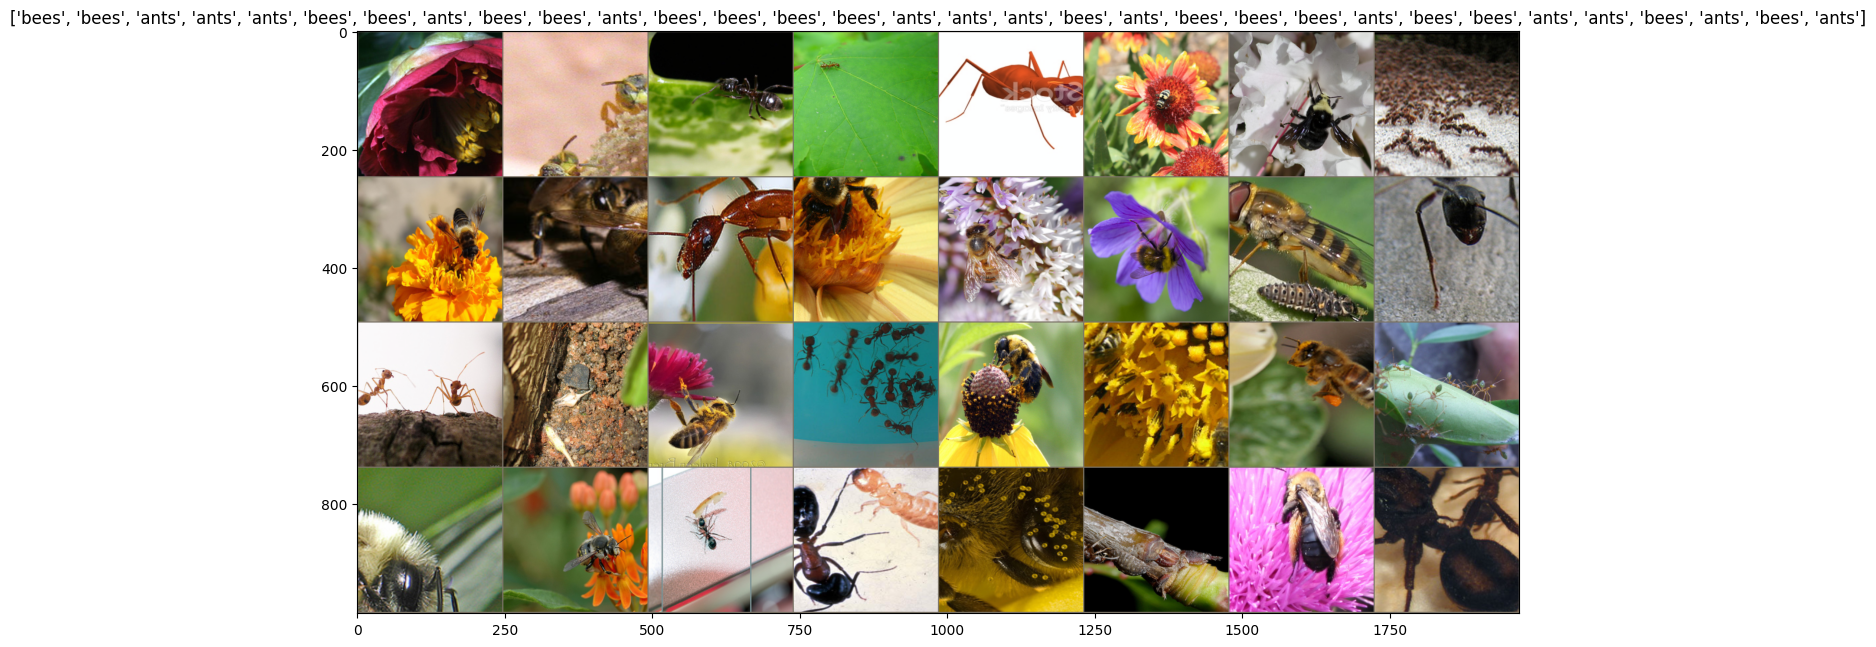

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

# Получим 1 батч (картинки-метки) из обучающей выборки
inputs, classes = next(iter(loaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
# Вместо pretrained используем weights=... и веса конкретной модели

In [29]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
for param in model.features.parameters():
    param.requires_grad = False

In [31]:
num_features = 4096

criterion = nn.CrossEntropyLoss()
model.classifier[6] = nn.Linear(num_features, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [32]:
def train(model, optimizer, criterion, max_epochs, loaders):
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    model.eval()
                    output = model(x_batch)
                predictions = output.argmax(-1)
                correct = (predictions == y_batch).sum()
                epoch_correct += correct.item()
                epoch_all += len(predictions)
                if k == "train":
                    loss = criterion(output, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

In [36]:
max_epochs = 15

train(model, optimizer, criterion, max_epochs, loaders)

Epoch: 1
Loader: train. Accuracy: 0.5409836065573771
Loader: valid. Accuracy: 0.5424836601307189
Epoch: 2
Loader: train. Accuracy: 0.680327868852459
Loader: valid. Accuracy: 0.673202614379085
Epoch: 3
Loader: train. Accuracy: 0.7581967213114754
Loader: valid. Accuracy: 0.7777777777777778
Epoch: 4
Loader: train. Accuracy: 0.8319672131147541
Loader: valid. Accuracy: 0.8823529411764706
Epoch: 5
Loader: train. Accuracy: 0.7991803278688525
Loader: valid. Accuracy: 0.6143790849673203
Epoch: 6
Loader: train. Accuracy: 0.8770491803278688
Loader: valid. Accuracy: 0.8954248366013072
Epoch: 7
Loader: train. Accuracy: 0.8442622950819673
Loader: valid. Accuracy: 0.869281045751634
Epoch: 8
Loader: train. Accuracy: 0.8934426229508197
Loader: valid. Accuracy: 0.9019607843137255
Epoch: 9
Loader: train. Accuracy: 0.8688524590163934
Loader: valid. Accuracy: 0.9019607843137255
Epoch: 10
Loader: train. Accuracy: 0.8934426229508197
Loader: valid. Accuracy: 0.8888888888888888
Epoch: 11
Loader: train. Accurac

In [38]:
model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [39]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [44]:
num_features = 512

model_resnet.fc = nn.Linear(num_features, 2)

optimizer = optim.Adam(model_resnet.fc.parameters(), lr=1e-3)

In [45]:
max_epochs = 10

train(model_resnet, optimizer, criterion, max_epochs, loaders)

Epoch: 1
Loader: train. Accuracy: 0.5409836065573771
Loader: valid. Accuracy: 0.8235294117647058
Epoch: 2
Loader: train. Accuracy: 0.7254098360655737
Loader: valid. Accuracy: 0.8627450980392157
Epoch: 3
Loader: train. Accuracy: 0.8278688524590164
Loader: valid. Accuracy: 0.8954248366013072
Epoch: 4
Loader: train. Accuracy: 0.8565573770491803
Loader: valid. Accuracy: 0.9084967320261438
Epoch: 5
Loader: train. Accuracy: 0.8688524590163934
Loader: valid. Accuracy: 0.9215686274509803
Epoch: 6
Loader: train. Accuracy: 0.8975409836065574
Loader: valid. Accuracy: 0.934640522875817
Epoch: 7
Loader: train. Accuracy: 0.9139344262295082
Loader: valid. Accuracy: 0.934640522875817
Epoch: 8
Loader: train. Accuracy: 0.9139344262295082
Loader: valid. Accuracy: 0.9281045751633987
Epoch: 9
Loader: train. Accuracy: 0.8811475409836066
Loader: valid. Accuracy: 0.9411764705882353
Epoch: 10
Loader: train. Accuracy: 0.9426229508196722
Loader: valid. Accuracy: 0.934640522875817
